In [1]:
import os
import warnings

os.environ['CUDA_VISIBLE_DEVICES'] = ''
warnings.filterwarnings('ignore')

In [2]:
import malaya_speech
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import malaya_speech.augmentation.waveform as augmentation
import random
import pandas as pd

In [3]:
from glob import glob
from collections import defaultdict

In [4]:
def get_data(combined_path, speakers_size = 4, sr = 22050):
    combined, _ = malaya_speech.load(combined_path, sr = sr, scale = False)
    y = []
    for i in range(speakers_size):
        y_, _ = malaya_speech.load(combined_path.replace('combined', str(i)), sr = sr, scale = False)
        y.append(y_)
    return combined, y

In [5]:
# combined, y = get_data(combined[0])
# plt.plot(combined)
# plt.plot(y[2])

In [6]:
librispeech = glob('../speech-bahasa/LibriSpeech/*/*/*/*.flac')

def get_speaker_librispeech(file):
    return file.split('/')[-1].split('-')[0]

speakers = defaultdict(list)
for f in librispeech:
    speakers[get_speaker_librispeech(f)].append(f)

vctk = glob('vtck/**/*.flac', recursive = True)
vctk_speakers = defaultdict(list)
for f in vctk:
    s = f.split('/')[-1].split('_')[0]
    vctk_speakers[s].append(f)

files = glob('../speech-bahasa/ST-CMDS-20170001_1-OS/*.wav')
speakers_mandarin = defaultdict(list)
for f in files:
    speakers_mandarin[f[:-9]].append(f)
len(speakers_mandarin)

speakers_malay = {}
speakers_malay['salina'] = glob(
    '/home/husein/speech-bahasa/salina/output-wav-salina/*.wav'
)
male = glob('/home/husein/speech-bahasa/turki/output-wav-turki/*.wav')
male.extend(
    glob('/home/husein/speech-bahasa/output-wav-dari-pasentran-ke-istana/*.wav')
)
speakers_malay['male'] = male
speakers_malay['haqkiem'] = glob('/home/husein/speech-bahasa/haqkiem/*.wav')
speakers_malay['khalil'] = glob('/home/husein/speech-bahasa/tolong-sebut/*.wav')
speakers_malay['mas'] = glob(
    '/home/husein/speech-bahasa/sebut-perkataan-woman/*.wav'
)
husein = glob('/home/husein/speech-bahasa/audio-wattpad/*.wav')
husein.extend(glob('/home/husein/speech-bahasa/audio-iium/*.wav'))
husein.extend(glob('/home/husein/speech-bahasa/audio/*.wav'))
husein.extend(glob('/home/husein/speech-bahasa/sebut-perkataan-man/*.wav'))
speakers_malay['husein'] = husein

df_nepali = pd.read_csv(
    '/home/husein/speech-bahasa/nepali_0/asr_nepali/utt_spk_text.tsv',
    sep = '\t',
    header = None,
)
asr_nepali = glob('/home/husein/speech-bahasa/*/asr_nepali/data/*/*.flac')
asr_nepali_replaced = {
    f.split('/')[-1].replace('.flac', ''): f for f in asr_nepali
}
df_nepali = df_nepali[df_nepali[0].isin(asr_nepali_replaced.keys())]

speakers_nepali = defaultdict(list)
for i in range(len(df_nepali)):
    speakers_nepali[df_nepali.iloc[i, 1]].append(
        asr_nepali_replaced[df_nepali.iloc[i, 0]]
    )
    
sr = 22050
speakers_size = 4

s = {
    **speakers,
    **vctk_speakers,
    **speakers_malay,
    **speakers_mandarin,
    **speakers_nepali,
}

keys = list(s.keys())

In [7]:
def random_speakers(n):
    ks = random.sample(keys, n)
    r = []
    for k in ks:
        r.append(random.choice(s[k]))
    return r


def read_wav(f):
    return malaya_speech.load(f, sr = sr)


def random_sampling(s, length):
    return augmentation.random_sampling(s, sr = sr, length = length)


def to_mel(y):
    mel = malaya_speech.featurization.universal_mel(y)
    mel[mel <= np.log(1e-2)] = np.log(1e-2)
    return mel


def combine_speakers(files, n = 5, limit = 4):
    w_samples = random.sample(files, n)
    w_samples = [read_wav(f)[0] for f in w_samples]
    w_lens = [len(w) / sr for w in w_samples]
    w_lens = int(min(min(w_lens) * 1000, random.randint(2000, 10000)))
    w_samples = [random_sampling(w, length = w_lens) for w in w_samples]
    y = [w_samples[0]]
    left = w_samples[0].copy()

    combined = None

    for i in range(1, n):
        right = w_samples[i].copy()
        overlap = random.uniform(0.98, 1.0)
        len_overlap = int(overlap * len(right))
        minus = len(left) - len_overlap
        if minus < 0:
            minus = 0
        padded_right = np.pad(right, (minus, 0))
        left = np.pad(left, (0, len(padded_right) - len(left)))

        left = left + padded_right

        if i >= (limit - 1):
            if combined is None:
                combined = padded_right
            else:
                combined = np.pad(
                    combined, (0, len(padded_right) - len(combined))
                )
                combined += padded_right

        else:
            y.append(padded_right)

    if combined is not None:
        y.append(combined)

    # for i in range(len(y)):
    #     if len(y[i]) != len(left):
    #         y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
    #         y[i] = y[i] / np.max(np.abs(y[i]))

    # left = left / np.max(np.abs(left))
    
    maxs = [max(left)]
    for i in range(len(y)):
        if len(y[i]) != len(left):
            y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
            maxs.append(max(y[i]))

    max_amp = max(maxs)
    mix_scaling = 1 / max_amp * 0.90
    left = left * mix_scaling

    for i in range(len(y)):
        y[i] = y[i] * mix_scaling

    return left, y

In [8]:
count = speakers_size
combined, y = combine_speakers(random_speakers(count), count)

In [9]:
len(y)

4

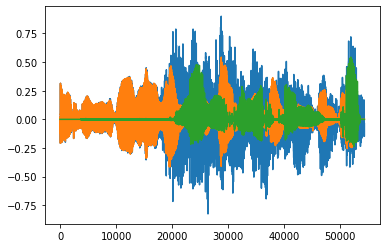

In [10]:
plt.plot(combined)
plt.plot(y[0])
plt.plot(y[1])

In [11]:
combined = to_mel(combined)
y = [to_mel(y_) for y_ in y]

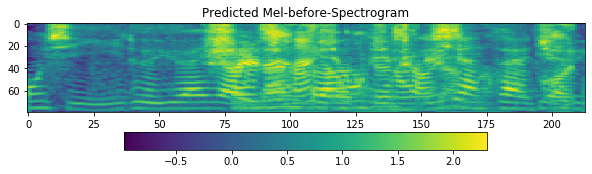

In [12]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(combined), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

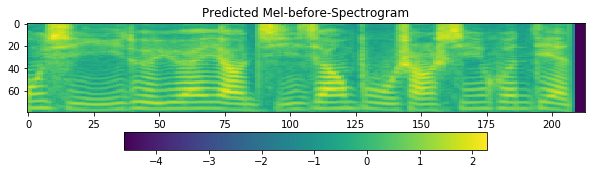

In [13]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(y[0]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

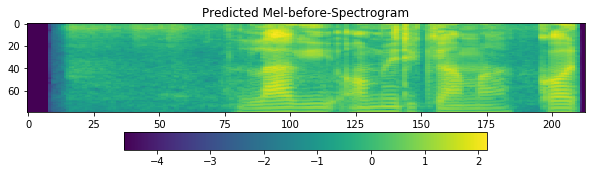

In [14]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(y[1]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

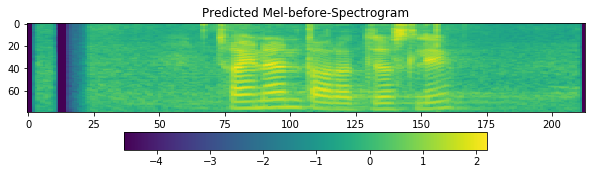

In [15]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(y[2]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

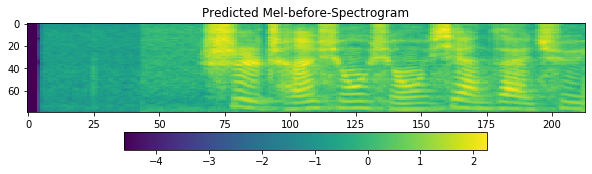

In [16]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(y[3]), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [17]:
directory = 'split-speaker-22k-train'
!mkdir {directory}
!mkdir {directory}/combined

mkdir: cannot create directory ‘split-speaker-22k-train’: File exists
mkdir: cannot create directory ‘split-speaker-22k-train/combined’: File exists


In [18]:
for i in range(speakers_size):
    os.system(f'mkdir {directory}/{i}')

In [21]:
from tqdm import tqdm
import soundfile as sf

def loop(files):
    files = files[0]
    for i in tqdm(files):
        try:
            combined, y = combine_speakers(random_speakers(count), count)
            sf.write(f'{directory}/combined/{i}.wav', combined, samplerate = sr)
            for k in range(speakers_size):
                sf.write(f'{directory}/{k}/{i}.wav', y[k], samplerate = sr)
        except:
            pass

In [22]:
import mp

mp.multiprocessing(range(100000), loop, cores = 20, returned = False)

100%|██████████| 5000/5000 [17:01<00:00,  4.90it/s]


In [ ]:
directory = 'split-speaker-22k-test'
!rm -rf directory
!mkdir {directory}
!mkdir {directory}/combined

In [ ]:
for i in range(speakers_size):
    os.system(f'mkdir {directory}/{i}')

In [ ]:
from tqdm import tqdm
import soundfile as sf

for i in tqdm(range(100)):
    try:
        combined, y = combine_speakers(random_speakers(count), count)
        sf.write(f'{directory}/combined/{i}.wav', combined, samplerate = sr)
        for k in range(speakers_size):
            sf.write(f'{directory}/{k}/{i}.wav', y[k], samplerate = sr)
    except:
        pass

In [ ]:
!du -hs split-speaker-22k-*

In [ ]:
!du -hs split-speaker-8k-*

In [ ]:
# !tar -czvf split-speaker-22k-test.tar.gz split-speaker-22k-test
# !tar -czvf split-speaker-8k-test.tar.gz split-speaker-8k-test